In [2]:
%pylab inline
import wfg
import sys
import rootpath
sys.path.append(rootpath.detect())
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist 

from igd_utilities import *
from testsuite.utilities import Pareto_split
from problem_setup import func, l, k, n_obj, n_dim

Populating the interactive namespace from numpy and matplotlib


In [27]:
def down_sample(y, out_size):
    """
    Down-samples point pool y to size out_size, keeping the 
    most sparse population possible.
    
    params:
        y [np.ndarray]: initial poolof points to be downsampled
        dimensions = [n_points, point_dim]
        out_size [int]: number of points in downsampled population
        muse be smaller than y.shape[0].
    """
    assert out_size<y.shape[0]
    pool = y.copy()
    in_pool = pool[:out_size] 
    out_pool = pool[out_size:] 
    M = distance_matrix(in_pool, in_pool)
    np.fill_diagonal(M, np.nan)
    for p in out_pool:
        arg_p = np.nanargmin(M)
        i = arg_p//M.shape[0]
        j = arg_p%M.shape[0]
        min_M = M[i,j]
        
        p_dist = cdist(p[np.newaxis,:], in_pool)[0]
        if p_dist.min()<min_M:
            # query point no improvement
            pass
        else:
            M[i] = p_dist 
            M[:, i] = p_dist.T
            M[i, i] = np.nan
            in_pool[i] = p
    return in_pool

In [28]:
def find_neighbours(pool, p, thresh, show_dist=False):
    D = distance_matrix(pool, p)
    pool_nn = np.min(D, axis=1)
    assert pool_nn.shape[0] == pool.shape[0]
    
    if show_dist:
        plt.hist(pool_nn, int(pool.shape[0]/2));
        plt.title('Attainment front->Pareto front nn distances');
        plt.axvline(thresh, c="C3", linestyle='--')
        
    api = pool_nn<thresh
    return api

In [29]:
def weak_dominates(Y, x):
    """
    Test whether rows of Y weakly dominate x
    
    Parameters
    ----------
    Y : array_like
        Array of points to be tested. 
        
    x : array_like
        Vector to be tested
        
    Returns
    -------
    c : ndarray (Bool)
        1d-array.  The ith element is True if Y[i] weakly dominates x
    """
    return (Y <= x ).sum(axis=1) == Y.shape[1]


def attainment_sample(Y, Nsamples=1000):
    """
    Return samples from the attainment surface defined by the mutually non-dominating set Y

    Parameters
    ---------
    Y : array_like
        The surface to be sampled. Each row of Y is vector, that is mutually
        with all the other rows of Y
    Nsamples : int
        Number of samples

    Returns
    -------
    S : ndarray
        Array of samples from the attainment surface.
        Shape; Nsamples by Y.shape[1] 
    
    Notes
    -----
    See "Dominance-based multi-objective simulated annealing"
    Kevin Smith, Richard Everson, Jonathan Fieldsend, 
    Chris Murphy, Rashmi Misra.
    IEEE Transactions on Evolutionary Computing. 
    Volume: 12, Issue: 3, June 2008.
    https://ieeexplore.ieee.org/abstract/document/4358782
    """
    N, D = Y.shape
    Ymin = Y.min(axis=0)
    r = Y.max(axis=0) - Ymin
    S = np.zeros((Nsamples, D))
    
    # Set up arrays of the points sorted according to each coordinate.
    Ys = np.zeros((N, D))
    for d in range(D):
        Ys[:,d] = np.sort(Y[:,d])

    for n in range(Nsamples):
        v = np.random.rand(D)*r + Ymin
        m = np.random.randint(D)

        # Bisection search to find the smallest v[m] 
        # so that v is weakly dominated by an element of Y
        lo, hi = 0, N
        while lo < hi:
            mid = (lo+hi)//2
            v[m] = Ys[mid,m]
            if not any(weak_dominates(Y, v)):
                lo = mid+1
            else:
                hi = mid
        if lo == N: lo -= 1
        v[m] = Ys[lo, m]      
        assert lo == N-1 or any(weak_dominates(Y, v))
        S[n,:] = v[:]
    return S


### 2D

In [3]:
M = n_obj
N = 1000 
y = np.zeros((N, n_obj))
x = np.zeros((N, n_dim))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__)
    y[n,:] = func(z, k, M)
    x[n,:] = z
    
pi, di = Pareto_split(y, return_indices=True)

assert pi.shape[0]+di.shape[0] == N
assert y.shape[1] == n_obj

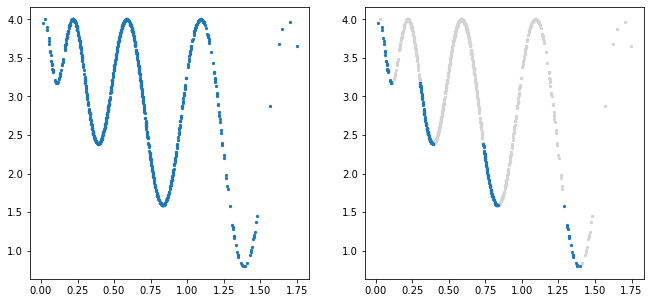

In [4]:
fig = figure(figsize=[11, 5])
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.scatter(*y.T, s=5)
ax2.scatter(*y[di].T, color="lightgrey", s=5)
ax2.scatter(*y[pi].T, color="C0", s=5)

### RME method

In [5]:
# rme gaps in data with n_rmees additional points. 
y_rme = y.copy()
x_rme = x.copy()

n_rmees = 5000
for i in range(n_rmees):
    diffs = y_rme[np.argsort(y_rme[:,0])][1:] -y_rme[np.argsort(y_rme[:,0])][:-1]
    gaps = np.array([np.sqrt(np.dot(diff, diff.T)) for diff in diffs])
    gap_m = np.argmax(gaps)
    gapi_x = x_rme[np.argsort(y_rme[:,0])][gap_m]
    gapj_x = x_rme[np.argsort(y_rme[:,0])][gap_m+1]
    fill_x = (gapi_x+gapj_x)/2
    fill_y = func(fill_x, k, M)
    
    assert fill_x.shape[0] == k+l
    assert fill_y.shape[0] == M
    
    y_rme = np.vstack((y_rme, fill_y))
    x_rme = np.vstack((x_rme, fill_x))
    
pi_rme, di_rme = Pareto_split(y_rme, return_indices=True) 

assert y_rme.shape[0] == y.shape[0]+n_rmees
assert x_rme.shape[0] == x.shape[0]+n_rmees

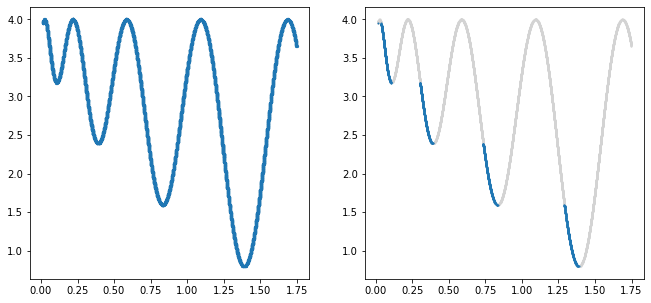

In [7]:
fig = figure(figsize=[11, 5])
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.scatter(*y_rme.T, s=5)
ax2.scatter(*y_rme[di_rme].T, color="lightgrey", s=1)
ax2.scatter(*y_rme[pi_rme].T, color="C0", s=1)

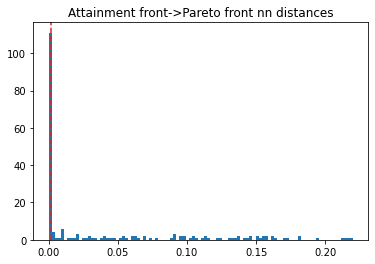

In [17]:
y_attainment = attainment_sample(y_rme[pi_rme], 200)
api_rme = find_neighbours(y_attainment, y_rme[pi_rme], 0.002, True)

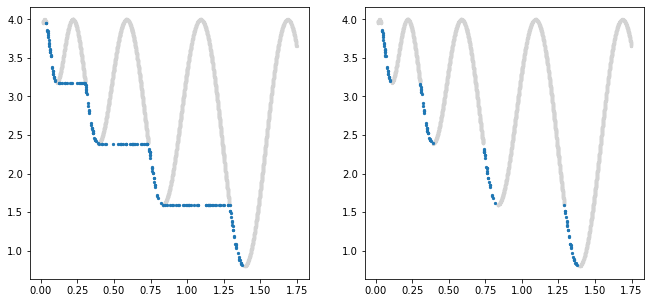

In [18]:
fig = figure(figsize=[11, 5])
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

ax1.scatter(*y_rme[di_rme].T, color="lightgrey", s=5)
ax1.scatter(*y_attainment.T, s=5)

ax2.scatter(*y_rme[di_rme].T, color="lightgrey", s=5)
ax2.scatter(*y_attainment[api_rme].T, s=5, c="C0")

### JEF Method

In [31]:
y.shape

(1000, 2)

In [32]:
y_jef = down_sample(y, 200)

In [33]:
y_jef.shape

(200, 2)

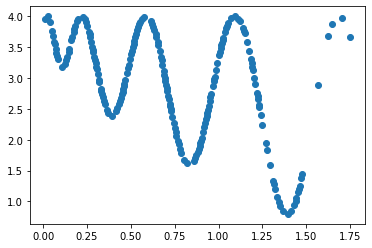

In [34]:
scatter(*y_jef.T)